## Colors of Central Cluster Galaxies
#### Compiled by Michael Wood-Vasey, based on work by Eli Rykoff and Dominique Boutigny
#### Last Verified to run: 2019-07-24

Do the measured extended magnitudes of central cluster galaxies make sense, and do they agree with the truth catalog?

A validation Notebook based on Eli Rykoff's cModelFlux investigation of colors of central cluster galaxies.  He found that the g-r colors were off at all redshifts, while the r-i and i-z colors were progressively better.  There was also a significant increased scatter in colors (~0.1-0.5 mag) not explained by the SNR.

The status as of the DESC Paris Collaboration Meeting (Jul 15-19, 2019) was "No".

This Notebook focuses on central (halo)cluster galaxies because they should follow a well-defined red sequence that's identifiable even if you don't have the truth information.

The color-color measurements for stars look totally fine.  See, e.g.,
[validate_dc2_run2.1i_object_table.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/rendered/validation/validate_dc2_run2.1i_object_table.ipynb)

Eli summarizes:  
"""
Here's what I think I know
- On an older dataset, with fewer epochs,  the cmodel mags with forced photometry in all but the detection band looked odd.   The metacal mags looked OK
- On the newer data set the two seem to agree pretty well
- On the newer data set the colors of central galaxies in clusters look wrong for both cmodel and metacal mags
- We wondered about background determination issues; @boutigny sent around plots and to me the background looks OK, much better than I would have expected actually.
- The images however look either very undersampled or they have been rebinned somehow; we need to sort that out
"""

Current Open Questions / Suggestions for Investigation:
1. Did we simulate these galaxies correctly?  In addition to checking CosmoDC2 "truth", check the as-realized fluxes in the centroid files from the input simulations to make sure those are reasonable.
2. Are we doing sky subtraction correctly, particular in crowded areas?
   a. Look at blended vs. isolated galaxies.  Although this isn't quite the same as sky subtraction issues likely can happen on a larger scale than galaxy-galaxy blend scale.
   b.  Look at postage stamps of the good galaxies and bad galaxies.  Produce both single-frame postage stamps and RGB color images where unphysical color gradients might be obvious.
3.  ....

In [1]:
import numpy as np

from astropy.table import Table

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import GCRCatalogs

In [4]:
import esutil

In [5]:
catalog_name = 'dc2_object_run2.1i_dr1'
cat = GCRCatalogs.load_catalog(catalog_name, config_overwrite={'use_cache': False})

In [6]:
data_quantities_wanted = ['objectId', 'parentObjectId', 'ra', 'dec',
                          'mag_g', 'mag_r', 'mag_i', 'mag_z',
                          'mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel', 'mag_z_cModel',
                          'magerr_g_cModel', 'magerr_r_cModel', 'magerr_i_cModel', 'magerr_z_cModel',
                          'blendedness', 'extendedness']
mag_z_cut_string = 'mag_z_cModel < 24.0'
query = GCRCatalogs.GCRQuery(mag_z_cut_string)

In [7]:
all_data = cat.get_quantities(data_quantities_wanted, [query])
all_data = Table(all_data)

In [8]:
print(f'Loaded {len(all_data)} objects with {mag_z_cut_string} from the Object Table')

Loaded 31335839 objects with mag_z_cModel < 24.0 from the Object Table


In [9]:
truthcat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image', config_overwrite={'use_cache': False})
truth_quantities_wanted = ['galaxy_id', 
                           'ra', 'dec', 'redshift', 
                           'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 
                           'halo_id', 'halo_mass', 'is_central', 'halo_mass']

In [10]:
general_galaxy_query = GCRCatalogs.GCRQuery('mag_z < 24.0')

all_truth_galaxies = truthcat.get_quantities(truth_quantities_wanted, [general_galaxy_query])
all_truth_galaxies = Table(all_truth_galaxies)

In [11]:
centrals = (all_truth_galaxies['is_central'] == True) & (all_truth_galaxies['halo_mass'] > 5e13)
all_truth_centrals = all_truth_galaxies[centrals]

In [13]:
satellites = (all_truth_galaxies['is_central'] == False) & (all_truth_galaxies['halo_mass'] > 5e13)
all_truth_satellites = all_truth_galaxies[satellites]

In [14]:
print(f'Loaded {len(all_truth_galaxies)} galaxies from the CosmoDC2 catalog')

Loaded 38682509 galaxies from the CosmoDC2 catalog


In [15]:
print(f'Loaded {len(all_truth_centrals)} central cluster galaxies from the CosmoDC2 catalog')

Loaded 30993 central cluster galaxies from the CosmoDC2 catalog


In [16]:
print(f'Loaded {len(all_truth_satellites)} satellite cluster galaxies from the CosmoDC2 catalog')

Loaded 881355 satellite cluster galaxies from the CosmoDC2 catalog


------
### Match data and truth catalog

In [19]:
htm_tree_depth = 12
htm_matcher = esutil.htm.Matcher(htm_tree_depth, all_data['ra'], all_data['dec'])
match_radius = 1 / 3600  # degrees

In [20]:
truth_centrals_match_idx, data_centrals_match_idx, dist = htm_matcher.match(all_truth_centrals['ra'], all_truth_centrals['dec'], match_radius, maxmatch=1)

In [25]:
data_centrals = all_data[data_centrals_match_idx]
truth_centrals = all_truth_centrals[truth_centrals_match_idx]

In [21]:
print(f'Matched {len(truth_centrals_match_idx)} objects between the Object Table and CosmoDC2 central cluster galaxies.')

Matched 21098 objects between the Object Table and CosmoDC2 central cluster galaxies.


In [22]:
truth_satellites_match_idx, data_satellites_match_idx, dist = htm_matcher.match(all_truth_satellites['ra'], all_truth_satellites['dec'], match_radius, maxmatch=1)

In [27]:
data_satellites = all_data[data_satellites_match_idx]
truth_satellites = all_truth_satellites[truth_satellites_match_idx]

In [24]:
print(f'Matched {len(truth_satellites_match_idx)} objects between the Object Table and CosmoDC2 satellite cluster galaxies.')

Matched 551992 objects between the Object Table and CosmoDC2 satellite cluster galaxies.


In [32]:
truth_galaxies_match_idx, data_galaxies_match_idx, dist = htm_matcher.match(all_truth_galaxies['ra'], all_truth_galaxies['dec'], match_radius, maxmatch=1)

In [33]:
data_galaxies = all_data[data_galaxies_match_idx]
truth_galaxies = all_truth_galaxies[truth_galaxies_match_idx]

In [34]:
print(f'Matched {len(truth_galaxies_match_idx)} objects between the Object Table and CosmoDC2 galaxies.')

Matched 22891909 objects between the Object Table and CosmoDC2 galaxies.


In [23]:
PICKLE_MATCHES = False

if PICKLE_MATCHES:
    import pickle

    with open('truth_data_galaxies_match_idx.pickle', 'wb') as f:
        pickle.dump((truth_galaxies_match_idx, data_galaxies_match_idx), f)

    with open('truth_galaxyId_data_objectId_match.pickle', 'wb') as f:
        pickle.dump((truth_galaxies['galaxy_id'], data_galaxies['objectId']), f)

------
### Color vs. Apparent Magnitude

In [28]:
def plot_gmr(df, ax=None, title=None, mag_type=None):
    if ax is None:
        ax = plt.gca()

    if mag_type is None or mag_type == '':
        mag_suffix = ''
    else:
        mag_suffix = f'_{mag_type}'
    
    band_0, band_1 = 'g', 'r'
    mag_0 = f'mag_{band_0}{mag_suffix}'
    mag_1 = f'mag_{band_1}{mag_suffix}'

    ax.hexbin(df[mag_0] - df[mag_1], df[mag_0], 
              bins='log',
              extent=(-2, 2, 16, 25))
    ax.set_xlabel(f'{mag_0} - {mag_1}')
    ax.set_ylabel(mag_0);
    ax.set_ylim(ax.get_ylim()[::-1]);
    if title is not None:
        ax.set_title(title)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract


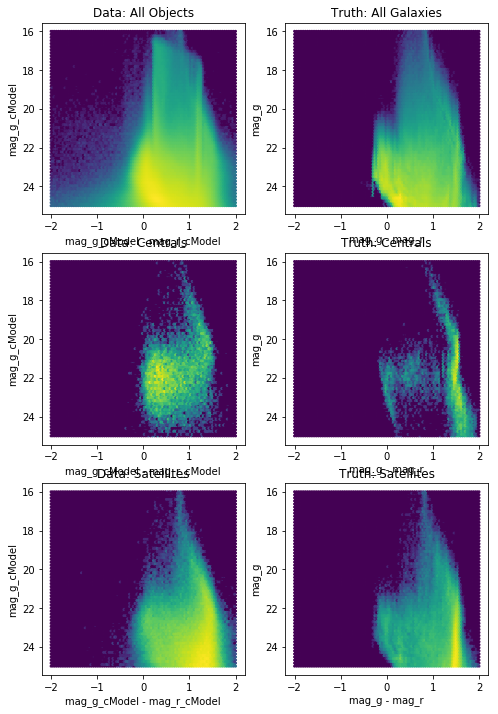

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
### Data in first column
plot_gmr(all_data, ax=ax[0, 0], mag_type='cModel', title='Data: All Objects')
plot_gmr(data_centrals, ax=ax[1, 0], mag_type='cModel', title='Data: Centrals')
plot_gmr(data_satellites, ax=ax[2, 0], mag_type='cModel', title='Data: Satellites')
### Truth in second column
plot_gmr(all_truth_galaxies, ax=ax[0, 1], title='Truth: All Galaxies')
plot_gmr(truth_centrals, ax=ax[1, 1], title='Truth: Centrals')
plot_gmr(truth_satellites, ax=ax[2, 1], title='Truth: Satellites')

------
## Compare observed and truth catalog magnitudes.

In [30]:
def plot_color_mag_redshift(true, df, mag_type='cModel'):
    redshift_range = [0, 3]
    mag_range = [16, 26]
    diff_range = [-4, +1]
    color_range = [-1, +2]

    if mag_type is None or mag_type == '':
        mag_suffix = ''
    else:
        mag_suffix = f'_{mag_type}'
    
    band_0, band_1 = 'g', 'r'
    mag_0 = f'mag_{band_0}'
    mag_1 = f'mag_{band_1}'
    mag_data_0 = f'{mag_0}{mag_suffix}'
    mag_data_1 = f'{mag_1}{mag_suffix}'

    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    ax[0, 0].hexbin(true[mag_0], df['mag_g_cModel'],
                 bins='log',
                 extent=mag_range + mag_range)
    ax[1, 0].hexbin(true[mag_0], df['mag_g_cModel'] - true[mag_0],
                 bins='log',
                 extent=mag_range + diff_range)

    ax[1, 0].set_xlabel(f'{mag_0} truth')
    ax[0, 0].set_ylabel(mag_0)
    ax[1, 0].set_ylabel(f'{mag_data_0} - {mag_0}_truth');

    ax[0, 1].hexbin(true['redshift'], df[mag_data_0],
                    bins='log',
                    extent=redshift_range + mag_range)
    ax[0, 1].set_ylabel(mag_data_0)

    ax[1, 1].hexbin(true['redshift'], df[mag_data_0] - true['mag_g'],
                     bins='log', 
                     extent=redshift_range + diff_range)
    ax[1, 1].set_xlabel('redshift')
    ax[1, 1].set_ylabel(f'{mag_data_0} - {mag_0}_truth');

    ax[0, 2].hexbin(df[mag_data_0] - df[mag_data_1], df[mag_data_0],
                    bins='log',
                    extent=color_range + mag_range)
    ax[0, 2].set_ylabel(mag_data_0);

    ax[1, 2].hexbin(df[mag_data_0] - df[mag_data_1], df[mag_data_0] - true[mag_0],
                     bins='log', 
                     extent=color_range + diff_range)
    ax[1, 2].set_xlabel(f'{mag_data_0} - {mag_data_1}')
    ax[1, 2].set_ylabel(f'{mag_data_0} - {mag_0}_truth');

    ax[0, 3].hexbin(true[mag_0] - true[mag_1], true[mag_0],
                    bins='log', 
                    extent=color_range + mag_range)
    ax[0, 3].set_ylabel(f'{mag_0}_truth');

    ax[1, 3].hexbin(true[mag_0] - true[mag_1], df[mag_data_0] - true[mag_0],
                    bins='log', 
                    extent=color_range + diff_range)
    ax[1, 3].set_xlabel(f'{mag_0}_truth - {mag_1}_truth')
    ax[1, 3].set_ylabel(f'{mag_data_0} - {mag_0}_truth');

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in subtract
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in subtract


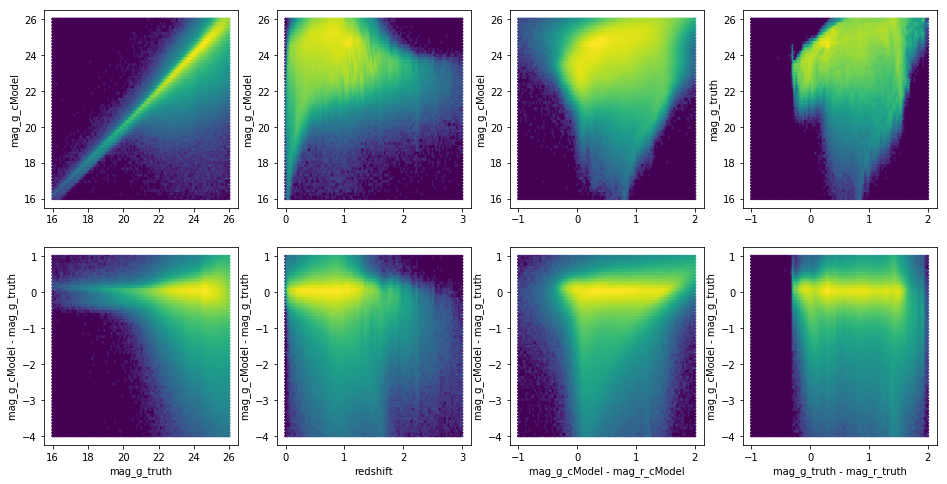

In [47]:
plot_color_mag_redshift(truth_galaxies, data_galaxies)

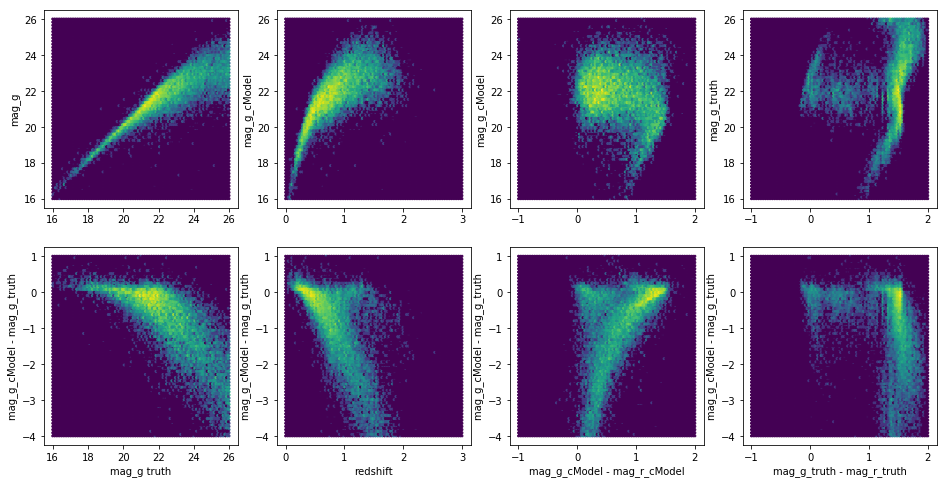

In [80]:
plot_color_mag_redshift(truth_centrals, data_centrals)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in subtract
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in subtract


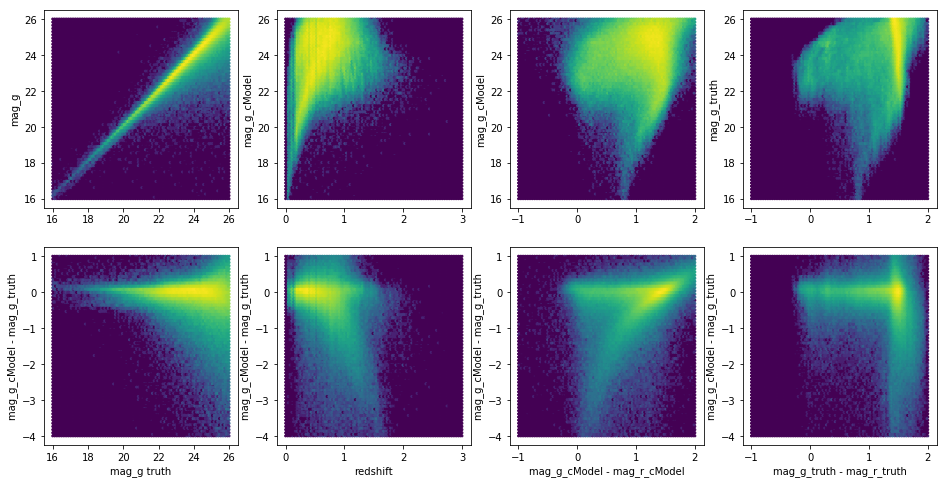

In [31]:
plot_color_mag_redshift(truth_satellites, data_satellites)

### Isolated Objects
Let's see what the isolated objects look like.  Isolated objects have no parent, so their `parentObjectId == 0`

In [52]:
unblended = data_galaxies['parentObjectId'] == 0

In [53]:
print(len(data_galaxies[unblended]))

7289572


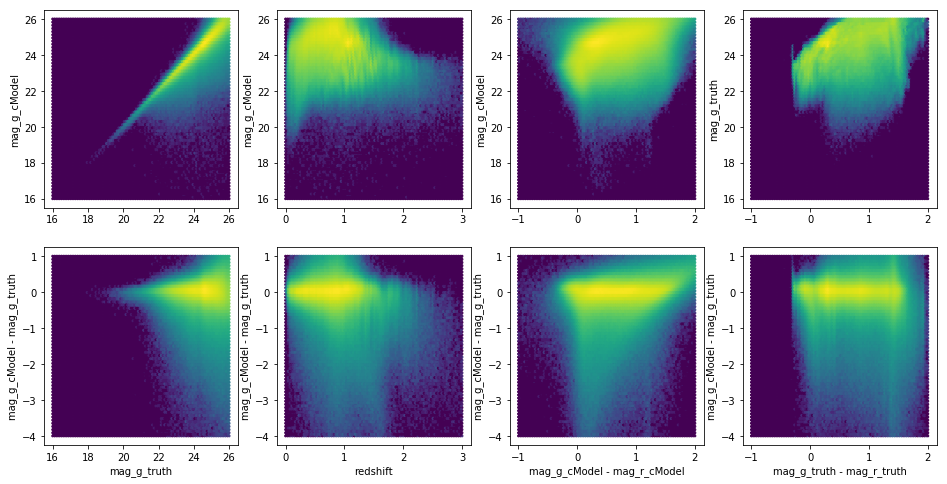

In [54]:
plot_color_mag_redshift(truth_galaxies[unblended], data_galaxies[unblended])

Text(0.5, 1.0, 'Truth: Central Cluster Galaxies')

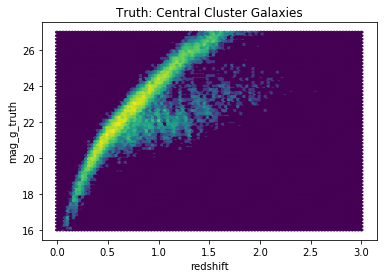

In [56]:
plt.hexbin(truth_centrals['redshift'], truth_centrals['mag_g'],
           bins='log', 
           extent=[0, 3, 16, 27])
plt.xlabel('redshift')
plt.ylabel('mag_g_truth');
plt.title('Truth: Central Cluster Galaxies')

In [36]:
def plot_number_density(true, df, nbins=15, bands=('g', 'r', 'z'), mag_type='cModel'):
    fig, axes = plt.subplots(1, len(bands), figsize=(12, 6))
    if mag_type is None or mag_type == '':
        mag_suffix = ''
    else:
        mag_suffix = f'_{mag_type}'
        
    for ax, band in zip(axes, bands):
        mag = f'mag_{band}'
        mag_cModel = f'{mag}{mag_suffix}'
        ax.hist([true[mag], df[mag_cModel]], nbins, range=(16, 25), histtype='step',
                 label=[f'{mag} true', mag_cModel], linewidth=2.0)
        ax.legend(loc='upper left');

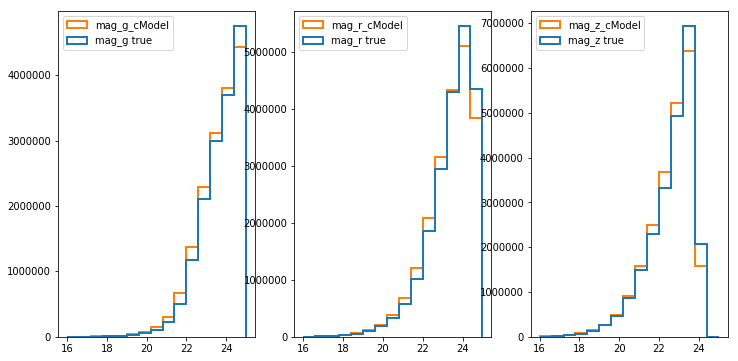

In [37]:
plot_number_density(truth_galaxies, data_galaxies)

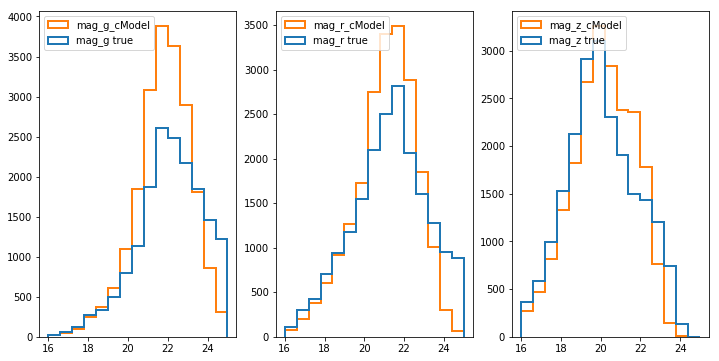

In [38]:
plot_number_density(truth_centrals, data_centrals)

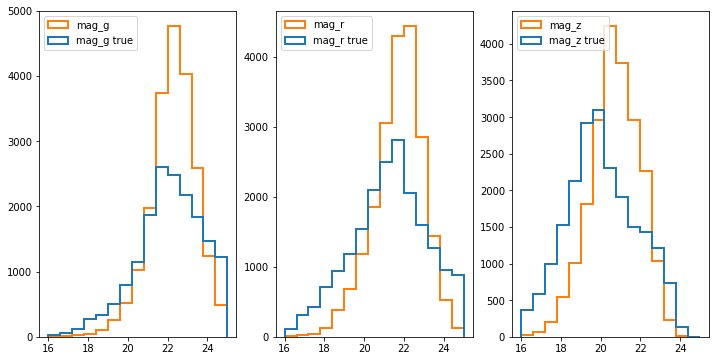

In [39]:
plot_number_density(truth_centrals, data_centrals, mag_type='')

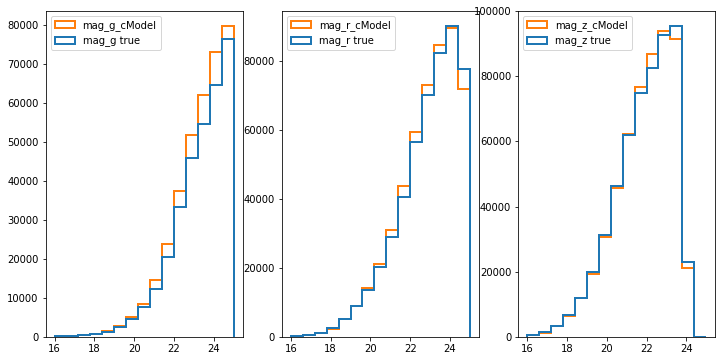

In [40]:
plot_number_density(truth_satellites, data_satellites, mag_type='cModel')

In [41]:
def plot_color_mag_color(df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    ax[0].hexbin(df['mag_g'] - df['mag_r'], df['mag_z'],
                 bins='log',
                 extent=(-1, 2, 16, 25))
    ax[0].set_xlabel('mag_g - mag_r')
    ax[0].set_ylabel('mag_z')
    ax[0].set_ylim(ax[0].get_ylim()[::-1])

    ax[1].hexbin(df['mag_g'] - df['mag_r'], df['mag_r'] - df['mag_z'],
                 bins='log',
                 extent=(-1, 2, -1, 3))
    ax[1].set_xlabel('mag_g - mag_r')
    ax[1].set_ylabel('mag_r - mag_z');

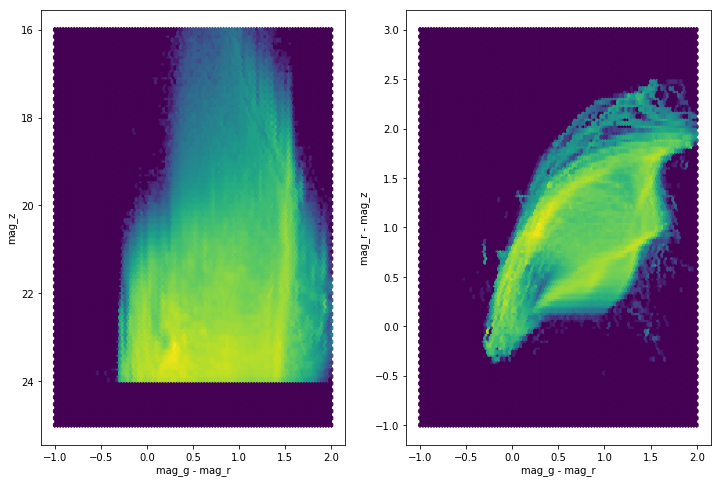

In [42]:
plot_color_mag_color(truth_galaxies)

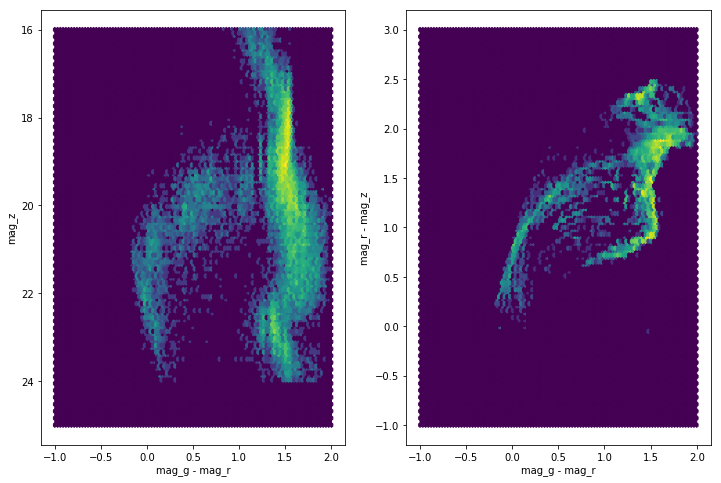

In [43]:
plot_color_mag_color(truth_centrals)

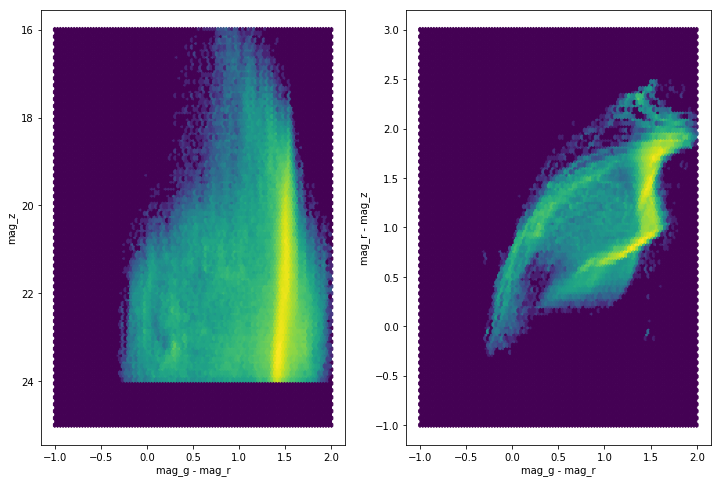

In [44]:
plot_color_mag_color(truth_satellites)

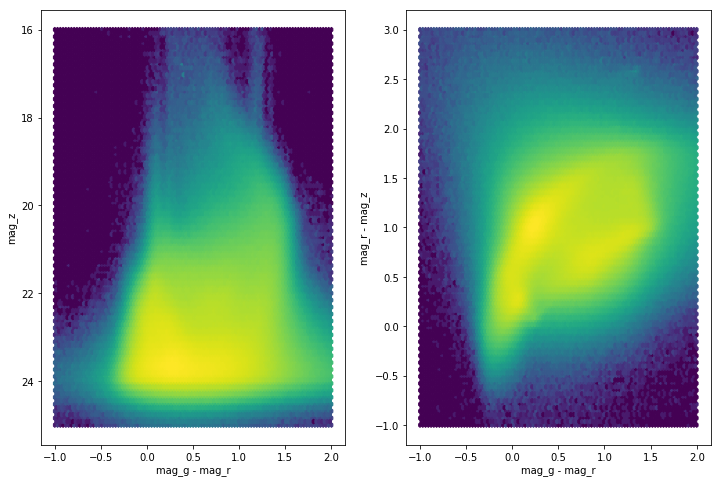

In [45]:
plot_color_mag_color(data_galaxies)

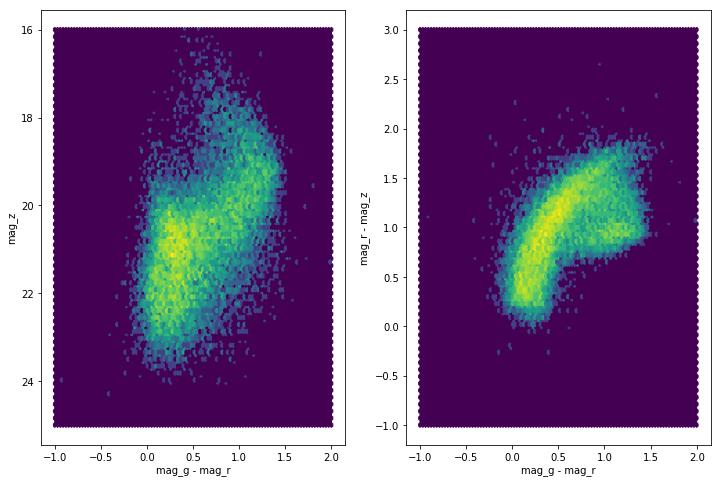

In [46]:
plot_color_mag_color(data_centrals)

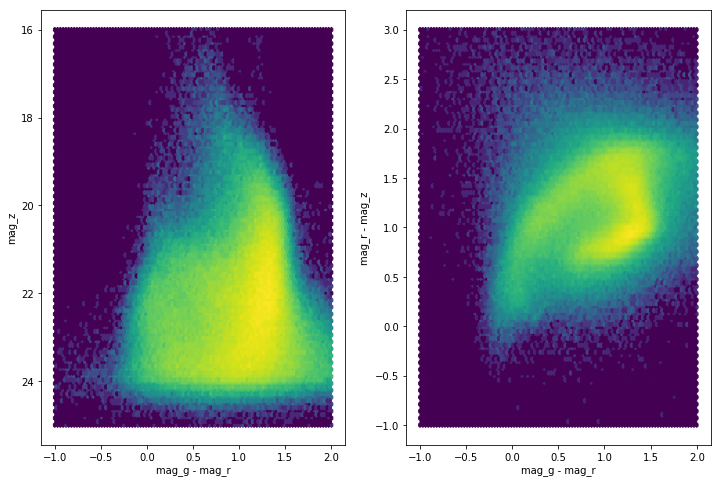

In [47]:
plot_color_mag_color(data_satellites)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract


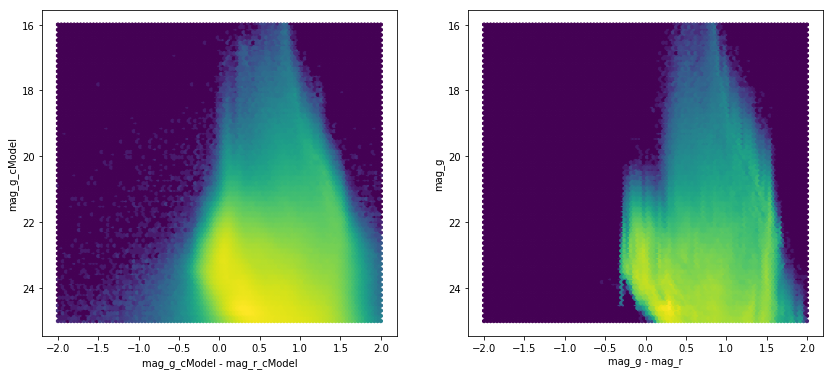

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_gmr(data_galaxies, ax=ax[0], mag_type='cModel')
plot_gmr(truth_galaxies, ax=ax[1])

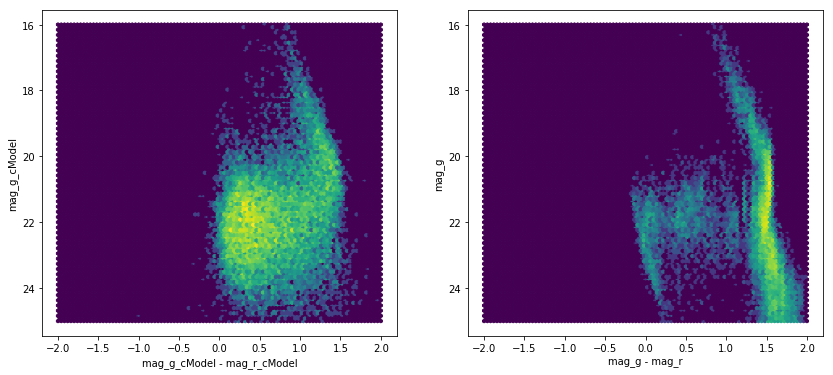

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_gmr(data_centrals, ax=ax[0], mag_type='cModel')
plot_gmr(truth_centrals, ax=ax[1])

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract


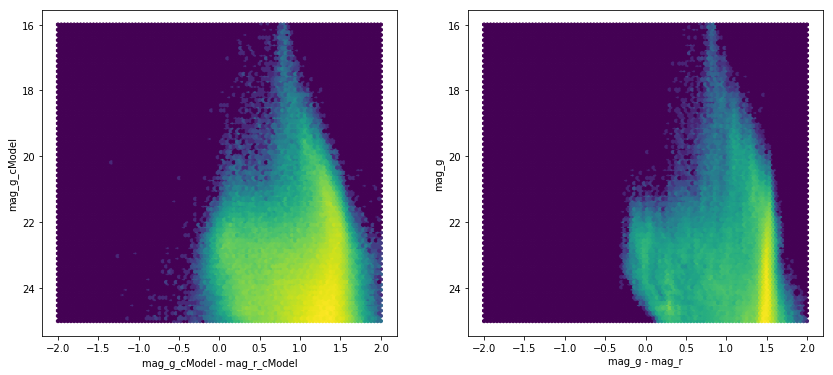

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_gmr(data_satellites, ax=ax[0], mag_type='cModel')
plot_gmr(truth_satellites, ax=ax[1])

### Look at all galaxies in similar color space

Let's explicitly compare the set of all galaxies with 1.3 < g-r < 1.7 mag and the cluster centrals.

In [274]:
galaxy_color = truth_galaxies['mag_g'] - truth_galaxies['mag_r']
red_galaxies = (1.3 < galaxy_color) & (galaxy_color < 1.7)

In [275]:
truth_red_galaxies = truth_galaxies[red_galaxies]
data_red_galaxies = data_galaxies[red_galaxies]

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in subtract
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in subtract


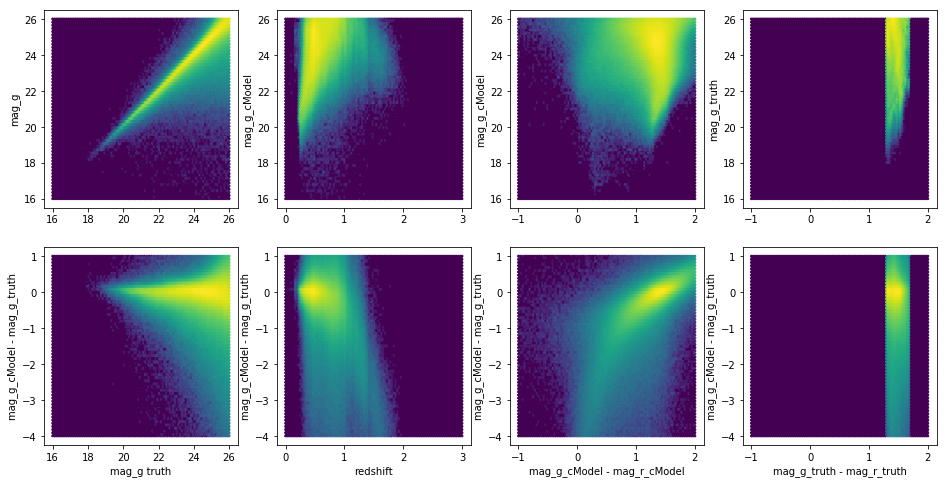

In [276]:
plot_color_mag_redshift(truth_red_galaxies, data_red_galaxies)

------
## psFlux magnitudes

So the cModel magnitudes look really bad.
Let's just look at the point-source magnitudes, `mag_{band}`, which are from the `psFlux_{band}` measurements.

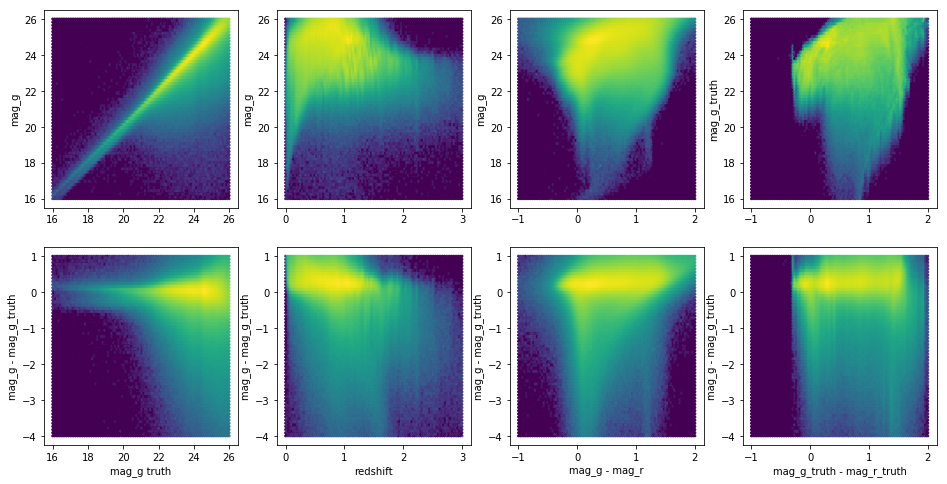

In [81]:
plot_color_mag_redshift(truth_galaxies, data_galaxies, mag_type='')

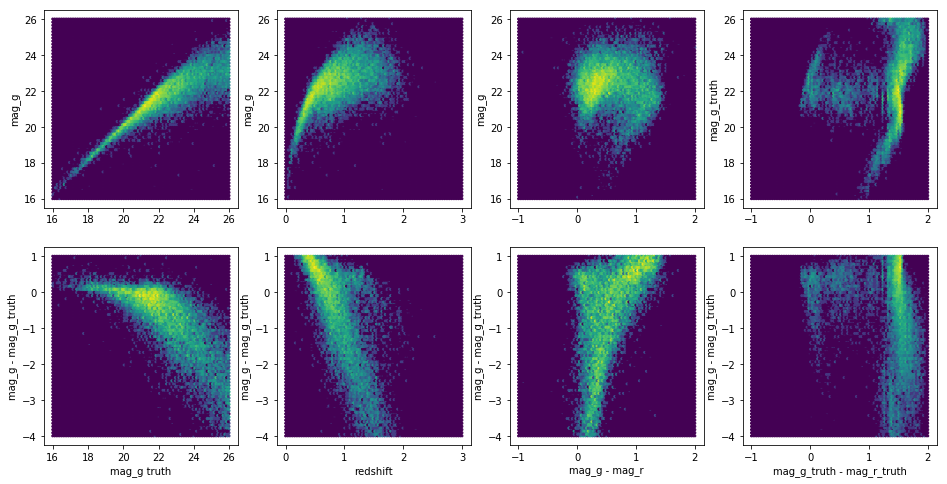

In [82]:
plot_color_mag_redshift(truth_centrals, data_centrals, mag_type='')

Still bad.

### Blendedness
This behavior is not a function of how blended an object is:

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

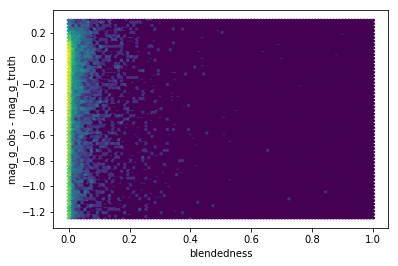

In [83]:
plt.hexbin(data_centrals['blendedness'],
           data_centrals['mag_g_cModel'] - truth_centrals['mag_g'],
           bins='log', 
           extent=[0, 1, -1.25, 0.3])
plt.xlabel('blendedness')
plt.ylabel('mag_g_obs - mag_g_truth')

------
### Metacal magnitudes
Metacal measurements show the same behavior of discrepant magnitudes for central cluster galaxies.
Those aren't included in the current Notebook to keep the column count lower for the full 30 million galaxies data catalog above

------
### Isolated Central Cluster Galaxies
Let's see what the isolated objects look like.  Isolated objects have no parent, so their `parentObjectId == 0`

In [57]:
isolated_centrals = data_centrals['parentObjectId'] == 0

In [58]:
print(f'There are {sum(isolated_centrals)} isolated central galaxies.')

There are 968 isolated central galaxies.


In [59]:
data_isolated_centrals = data_centrals[isolated_centrals]
truth_isolated_centrals = truth_centrals[isolated_centrals]

Text(0, 0.5, 'mag_g_obs')

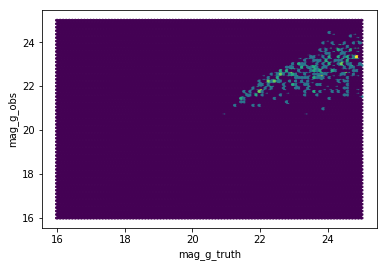

In [60]:
plt.hexbin(truth_isolated_centrals['mag_g'], data_isolated_centrals['mag_g_cModel'],
           bins='log', extent=[16, 25, 16, 25])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs')

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

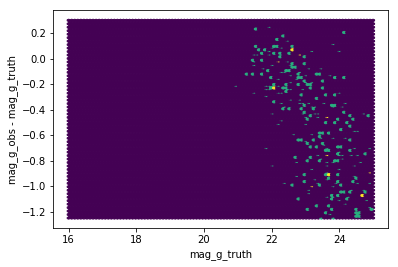

In [61]:
plt.hexbin(truth_isolated_centrals['mag_g'],
           data_isolated_centrals['mag_g_cModel'] - truth_isolated_centrals['mag_g'],
           bins='log',
           extent=[16, 25, -1.25, 0.3])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs - mag_g_truth')

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

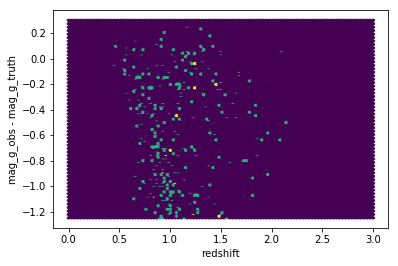

In [62]:
plt.hexbin(truth_isolated_centrals['redshift'],
           data_isolated_centrals['mag_g_cModel'] - truth_isolated_centrals['mag_g'],
           bins='log',
           extent=[0, 3, -1.25, 0.3])
plt.xlabel('redshift')
plt.ylabel('mag_g_obs - mag_g_truth')

------


### Postage Stamps

Let's look at some postage stamps of the isolated central cluster galaxies

In [63]:
from lsst.daf.persistence import Butler
import lsst.afw.geom as afwGeom

In [64]:
butler = Butler('/global/projecta/projectdirs/lsst/production/DC2_ImSim/Run2.1i/desc_dm_drp/w_2019_19-v1/rerun/coadd-dr1b-v1-grizy')

Pick a tract, patch

In [65]:
# tract, (patchx, patchy) = 4024, (3, 3)
# The isolated central galaxy in this tract shows a significant difference
tract, (patchx, patchy) = 2900, (1, 2)

patch = f'{patchx},{patchy}'
band = 'g'
coadd_id = {'tract': tract, 'patch': patch, 'filter': band}

Find all of the objects from above in that tract, patch

In [66]:
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[tract]
patch_info = tract_info.getPatchInfo((patchx, patchy))

patch_box = afwGeom.Box2D(patch_info.getInnerBBox())
patch_pos_list = patch_box.getCorners()
wcs = tract_info.getWcs()
corners = wcs.pixelToSky(patch_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [67]:
patch_info.getInnerBBox()

Box2I(minimum=Point2I(4000, 8000), dimensions=Extent2I(4000, 4000))

In [68]:
print(corners)

[[ 57.724215   -44.21497907]
 [ 57.41419267 -44.21665604]
 [ 57.41245475 -43.9944447 ]
 [ 57.72131871 -43.99278065]]


In [69]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [70]:
idx = (min_ra < truth_isolated_centrals['ra']) & (truth_isolated_centrals['ra'] < max_ra) & \
      (min_dec < truth_isolated_centrals['dec']) & (truth_isolated_centrals['dec'] < max_dec)

In [71]:
truth_in_patch = truth_isolated_centrals[idx]
data_in_patch = data_isolated_centrals[idx]

In [72]:
print(len(data_in_patch))

1


# Load coadd for tract, patch

In [73]:
coadd = butler.get(datasetType='deepCoadd', dataId=coadd_id)

Make postage stamps for random subsample of N=10 from that tract, patch

If we're looking just at isolated sources, N might just be 1, but if we start looking at larger samples, it will be useful to take random subsamples.

In [74]:
from numpy.random import choice

In [75]:
n = 1
subsample = choice(np.arange(len(data_in_patch)), n)

In [76]:
subsample

array([0])

In [77]:
data_in_patch[subsample]

<Table length=1>
extendedness    mag_r_cModel    ... parentObjectId         ra       
  float64         float64       ...     int64           float64     
------------ ------------------ ... -------------- -----------------
         1.0 22.909496465933902 ...              0 57.43290160039777

In [78]:
truth_in_patch[subsample]

<Table length=1>
      mag_y           halo_mass      ... is_central        ra      
     float64           float64       ...    bool        float64    
----------------- ------------------ ... ---------- ---------------
20.44807804426843 127947184445295.78 ...       True 57.432902676666

In [87]:
print('      Data - Truth')
print('band cModel  ps')
for band in ('g', 'r', 'i', 'z'):
    diff_cModel = data_in_patch[f'mag_{band}_cModel'] - truth_in_patch[f'mag_{band}']
    diff = data_in_patch[f'mag_{band}'] - truth_in_patch[f'mag_{band}']

    print(f'{band:<4s} {diff[0]:+0.3f} {diff[0]:+0.3f} mag')

      Data - Truth
band cModel  ps
g    -0.060 -0.060 mag
r    +0.580 +0.580 mag
i    +0.652 +0.652 mag
z    +0.869 +0.869 mag


In [88]:
from lsst.geom import SpherePoint

ra, dec = data_in_patch[0]['ra', 'dec']
radec = SpherePoint(ra, dec, afwGeom.degrees)

cutout_size = 51
cutout_extent = afwGeom.ExtentI(cutout_size, cutout_size)
cutout_image = coadd.getCutout(radec, cutout_extent)

In [89]:
import lsst.afw.display as afwDisplay

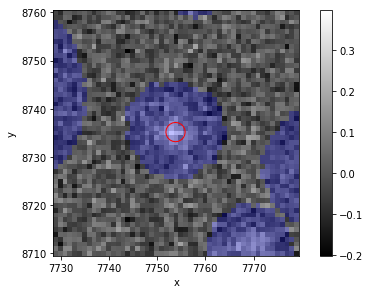

In [90]:
backend = 'matplotlib'
frame=1

display = afwDisplay.Display(frame=frame, backend=backend)

xy = cutout_image.getWcs().skyToPixel(radec)

display.mtv(cutout_image)
display.scale("linear", "zscale")
display.dot('o', xy.getX(), xy.getY(), ctype='red')
display.show_colorbar()

plt.xlabel('x');
plt.ylabel('y');

In [91]:
butler.getUri(datasetType='deepCoadd', dataId=coadd_id)

'/global/projecta/projectdirs/lsst/production/DC2_ImSim/Run2.1i/desc_dm_drp/w_2019_19-v1/rerun/coadd-dr1b-v1-grizy/deepCoadd/g/2900/1,2.fits'

In [92]:
print(xy)

(7753.8, 8735.2)
